In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
#import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm

import xesmf as xe
#from pykrige.ok import OrdinaryKriging
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils

In [2]:
#import data from:
### Gallagher, Kevin P. (2021), “China’s Global Energy Finance,” Global Development Policy Center, Boston University.
### Gallagher, Kevin P., Li, Zhongshu, Chen, Xu, Ma, Xinyue (2019), “China’s Global Power Database,” Global Development Policy Center, Boston University.

In [3]:
CGP_df = pd.read_excel('BU_data/CGP-Database_2020-1-2.xlsx')

In [4]:
CGP_df = CGP_df.loc[CGP_df['Technology'] == 'Coal']

In [5]:
#CGEF_df['Country'] = CGEF_df['Country'].str.lower()
CGP_df['Country'] = CGP_df['Country'].str.lower()

for idx in CGP_df.index:
    geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
    location = geolocator.geocode([CGP_df['State'].loc[idx],CGP_df['Country'].loc[idx]])
    CGP_df.loc[idx, 'lat'] = location.latitude + np.random.normal(0,.0001,1) #adding small random noise so that lats and lons don't repeat for plants in same county
    CGP_df.loc[idx, 'lon'] = location.longitude + np.random.normal(0,.0001,1) #adding small random noise so that lats and lons don't repeat for plants in same county
    CGP_df.loc[idx, 'location'] = location[0]

In [6]:
## https://pubs.acs.org/doi/abs/10.1021/es3003684 Table S1 
EF = np.exp(-3.64) #g/kg BC/coal

## https://www.nap.edu/read/9736/chapter/8 
HHF = 22.51 #GJ/t

#conversion factors
GJ_to_MwH = .28

Mw_to_MwH = 24 #daily

ton_to_kg = 0.001 #metric tons

MW_gpDay = Mw_to_MwH/GJ_to_MwH/HHF*ton_to_kg*EF #g/day


In [7]:
years = 50
coal_year_range = np.arange(0,41)

In [8]:
## Add time dimension
length_simulation = years*365

time_array = np.arange(0, length_simulation)

In [9]:
CGP_df = CGP_df.loc[CGP_df['Region'] == 'Southeast Asia']

In [10]:
CGP_df.loc[:,'BC (g/day)'] = CGP_df['Capacity (MW)']*MW_gpDay

In [11]:
CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

In [12]:
CGP_df.loc[CGP_df.Year_of_Commission == 'Pending', 'Year_of_Commission'] = 9999

In [13]:
CGP_df['CO2_weighted_capacity_1000tonsperMW'] = CGP_df['Estimated_Annual_CO2_Emission_from_Power_Generation_(1000_ton)']/CGP_df['Capacity_(MW)']

In [14]:
CGP_op = CGP_df.loc[CGP_df['Project_Status'] == 'In Operation']

Questions on data:
    
    1. changing the BC emissions factor by type of fuel
    2. changing emissions over time
    

In [15]:
def early_retirement_by_CO2(years, df, CO2_val, time_array):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    E = {}
    for year in np.arange(0,years):
        E[year] = np.zeros(len(time_array))
        #print(year_comis)
        #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        test_array = np.where(time_array <= year*365, True, False)
        #plt.plot(test_array)
        E[year] += test_array* df.loc[df.CO2_weighted_capacity_1000tonsperMW >= CO2_val]['BC_(g/day)'].sum()
        E[year] += (time_array>=0) * CGP_op.loc[CGP_op.CO2_weighted_capacity_1000tonsperMW < CO2_val]['BC_(g/day)'].sum()
        #plt.plot(E)
    return(E)

In [16]:
#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    min_comission_yr = df['Year_of_Commission'].min()
    shutdown_days = shutdown_years*365
    E = np.zeros(len(time_array))
        #print(year_comis)
    #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
    test_array = np.where(time_array <= year_early*365, True, False)
    #plt.plot(test_array)
    E += test_array* df.loc[df.CO2_weighted_capacity_1000tonsperMW >= CO2_val]['BC_(g/day)'].sum()
        #fig, ax = plt.subplots()
        #plt.plot(E[year])
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        test_array = np.where((time_array <= (year_comis-min_comission_yr)*365 + shutdown_days), True, False)
        #fig, ax = plt.subplots()
        #plt.plot(test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum())
        E += test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum()
        #E[year] += (time_array>=0) * df.loc[df.CO2_weighted_capacity_1000tonsperMW < CO2_val]['BC_(g/day)'].sum()
        #plt.plot(E)

    
    return(E)



In [17]:
E_heavy_emit_year = early_retirement_by_CO2_year(20, CGP_op, CGP_df['CO2_weighted_capacity_1000tonsperMW'].max(), time_array, 40)

In [18]:
def early_retirement_by_CO2_2x(year_early, year_early2, df, CO2_val, CO2_val2, time_array):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    E = np.zeros(len(time_array))
        #print(year_comis)
    #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
    test_array = np.where(time_array <= year_early*365, True, False)
    #plt.plot(test_array)
    E += test_array* df.loc[df.CO2_weighted_capacity_1000tonsperMW >= CO2_val]['BC_(g/day)'].sum()
    #plt.plot(test_array)
    #plt.plot(E)
    test_array2 = np.where((time_array <= year_early2*365), True, False)
    
    E += test_array2 * df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.CO2_weighted_capacity_1000tonsperMW >= CO2_val2)]['BC_(g/day)'].sum()
    #plt.plot(test_array2 * df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.CO2_weighted_capacity_1000tonsperMW >= CO2_val2)]['BC_(g/day)'].sum())
    
    E += (time_array>=0) * df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val2)]['BC_(g/day)'].sum()

    return(E)

In [19]:
E_double_CO2_retired = early_retirement_by_CO2_2x(20, 20, CGP_op, CGP_op['CO2_weighted_capacity_1000tonsperMW'].mean(), 
                                          0, time_array)

In [20]:
E_CO2_40yr_other = {}
for year in coal_year_range:
    E_CO2_40yr_other[year] = early_retirement_by_CO2_year(year, CGP_op, CGP_df['CO2_weighted_capacity_1000tonsperMW'].max(), time_array, 40)
    

In [86]:
range_dict = {'mean':CGP_df['CO2_weighted_capacity_1000tonsperMW'].mean(), 
    'mean+1':CGP_df['CO2_weighted_capacity_1000tonsperMW'].mean() + 1*CGP_df['CO2_weighted_capacity_1000tonsperMW'].std(), 
    'max':CGP_df['CO2_weighted_capacity_1000tonsperMW'].max() , 
    'mean-1':CGP_df['CO2_weighted_capacity_1000tonsperMW'].mean() - 1*CGP_df['CO2_weighted_capacity_1000tonsperMW'].std(), 
    'min':CGP_df['CO2_weighted_capacity_1000tonsperMW'].min() }

In [106]:
E_CO2_range_max_20yr = {}
for r in np.arange(1,101):
    E_CO2_range_max_20yr[r] = early_retirement_by_CO2_year(20, CGP_op, np.percentile(CGP_op['CO2_weighted_capacity_1000tonsperMW'],r), time_array, 40)
    

In [105]:
E_CO2_range_max_allyr = {}
for year in coal_year_range:
    E_CO2_range_max_allyr[year] = {}
    for r in np.arange(1,101):
        E_CO2_range_max_allyr[year][r] = early_retirement_by_CO2_year(year, CGP_op, np.percentile(CGP_op['CO2_weighted_capacity_1000tonsperMW'],r), time_array, 40)


In [28]:

E_CO2_all_opts = {}
for year in coal_year_range:
    E_CO2_all_opts[year] = {}
    for year_ret in coal_year_range:
        E_CO2_all_opts[year][year_ret] = early_retirement_by_CO2_year(year, CGP_op, CGP_df['CO2_weighted_capacity_1000tonsperMW'].max(), time_array, year_ret)
    
    
   
   

# Create Scenarios

In [29]:
def early_retirement_by_year(shutdown_years, df):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    min_comission_yr = df['Year_of_Commission'].min()
    shutdown_days = shutdown_years*365

    E = np.zeros(len(time_array))
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        test_array = np.where((time_array < (year_comis-min_comission_yr)*365 + shutdown_days) & (time_array >= (year_comis-min_comission_yr)*365), True, False)
        #plt.plot(test_array)
        E += test_array* df.loc[df.Year_of_Commission == year_comis]['BC_(g/day)'].sum()
        #plt.plot(E)
        #E += (time_array>=0) * df.loc[df.Year_of_Commission < year_comis]['BC_(g/day)'].sum()
    return(E)

In [30]:
E = {}
for year in coal_year_range:
    E[year] = early_retirement_by_year(year, CGP_op)

## Plots of scenarios

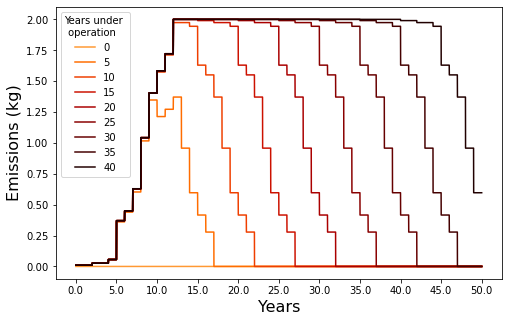

In [114]:
fig, ax = plt.subplots(figsize = [8,5])
color = iter(cm.gist_heat_r(np.linspace(0.2, 1, 10)))
for year in coal_year_range[::5]:
    c = next(color)
    plt.plot(E[year], color = c, label = f'{year}')
#for year in [5,10,15,20,25,30,35,40]:
    #plt.axvline(x=year*365, color = 'k', linestyle = ':')
plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions (kg)',fontsize = 16)
ax.set_xticks(np.linspace(0, length_simulation, 11))
# Set the tick labels
ax.set_xticklabels(np.linspace(0, years, 11));
plt.legend(title = 'Years under \n operation')
    
#plt.xlim(0,500)

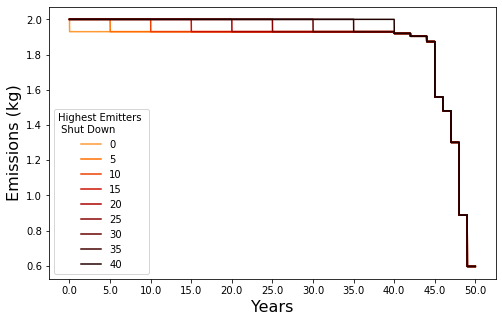

In [25]:

fig, ax = plt.subplots(figsize = [8,5])
color = iter(cm.gist_heat_r(np.linspace(0.2, 1, 10)))
for year in coal_year_range[::5]:
    c = next(color)
    plt.plot(E_CO2_40yr_other[year], color = c, label = f'{year}')
#for year in [5,10,15,20,25,30,35,40]:
    #plt.axvline(x=year*365, color = 'k', linestyle = ':')
plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions (kg)',fontsize = 16)
ax.set_xticks(np.linspace(0, length_simulation, 11))
# Set the tick labels
ax.set_xticklabels(np.linspace(0, years, 11));
plt.legend(title = 'Highest Emitters \n Shut Down')
    
#plt.xlim(0,500)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


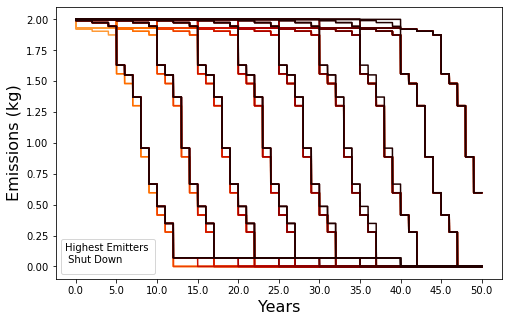

In [60]:
fig, ax = plt.subplots(figsize = [8,5])
color = iter(cm.gist_heat_r(np.linspace(0.2, 1, 10)))
for year in coal_year_range[::5]:
    c = next(color)
    for year_ret in coal_year_range[::5]:
    
        plt.plot(E_CO2_all_opts[year][year_ret], color = c)#, label = f'{year}')
#for year in [5,10,15,20,25,30,35,40]:
    #plt.axvline(x=year*365, color = 'k', linestyle = ':')
plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions (kg)',fontsize = 16)
ax.set_xticks(np.linspace(0, length_simulation, 11))
# Set the tick labels
ax.set_xticklabels(np.linspace(0, years, 11));
plt.legend(title = 'Highest Emitters \n Shut Down')
    
#plt.xlim(0,500)

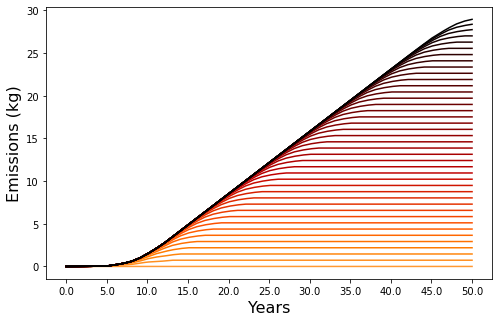

In [113]:
fig, ax = plt.subplots(figsize = [8,5])
color = iter(cm.gist_heat_r(np.linspace(0.2, 1, 41)))
for year in coal_year_range:
    c = next(color)
    plt.plot(E[year].cumsum()/1e3, color = c)
plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions (kg)',fontsize = 16)
ax.set_xticks(np.linspace(0, length_simulation, 11))
# Set the tick labels
ax.set_xticklabels(np.linspace(0, years, 11));
#plt.xlim(0,500)
#plt.legend(title = 'Years under \n operation')


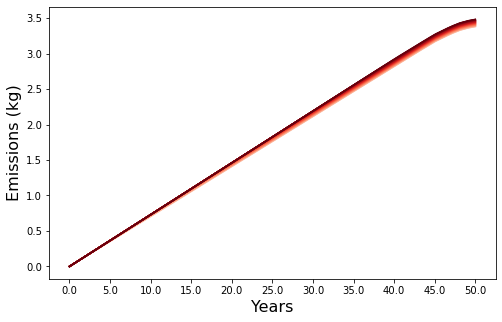

In [92]:
fig, ax = plt.subplots(figsize = [8,5])
color = iter(cm.Reds(np.linspace(0.2, 1, 41)))
for year in coal_year_range:
    c = next(color)
    plt.plot(E_CO2_40yr_other[year].cumsum()/1e4, color = c)
plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions (kg)',fontsize = 16)
ax.set_xticks(np.linspace(0, length_simulation, 11))
# Set the tick labels
ax.set_xticklabels(np.linspace(0, years, 11));
#plt.xlim(0,500)
#plt.legend(title = 'Years under \n operation')


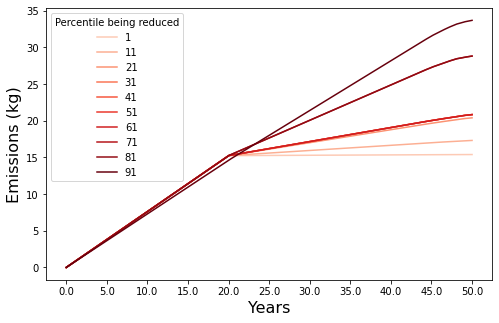

In [127]:
fig, ax = plt.subplots(figsize = [8,5])
color = iter(cm.Reds(np.linspace(0.2, 1, 10)))
for r in list(E_CO2_range_max_20yr.keys())[::10]:
    c = next(color)
    plt.plot(E_CO2_range_max_20yr[r].cumsum()/1e3, color = c, label = r)
plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions (kg)',fontsize = 16)
ax.set_xticks(np.linspace(0, length_simulation, 11))
# Set the tick labels
ax.set_xticklabels(np.linspace(0, years, 11));
#plt.xlim(0,500)
plt.legend(title = 'Percentile being reduced',loc=  'upper left')


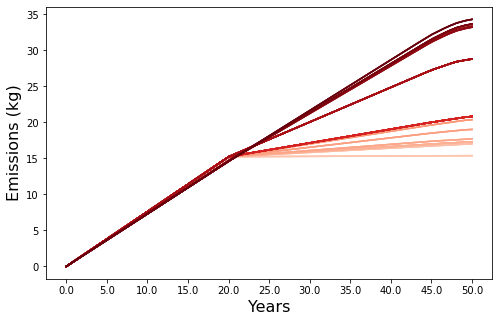

In [128]:
fig, ax = plt.subplots(figsize = [8,5])
color = iter(cm.Reds(np.linspace(0.2, 1, 100)))
for r in list(E_CO2_range_max_20yr.keys()):
    c = next(color)
    plt.plot(E_CO2_range_max_20yr[r].cumsum()/1e3, color = c)
plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions (kg)',fontsize = 16)
ax.set_xticks(np.linspace(0, length_simulation, 11))
# Set the tick labels
ax.set_xticklabels(np.linspace(0, years, 11));
#plt.xlim(0,500)
#plt.legend(title = 'Years under \n operation',loc=  'upper left')


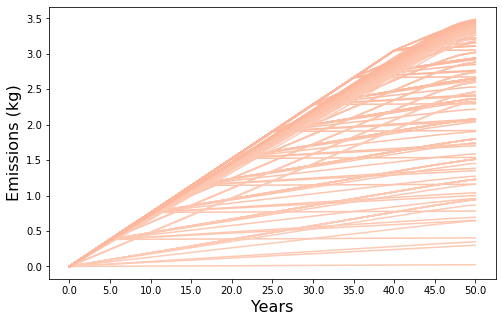

In [109]:
fig, ax = plt.subplots(figsize = [8,5])
#color = iter(cm.Reds(np.linspace(0.2, 1, 51)))
for r in np.arange(1,100)[::5]:
    color = iter(colors_dict[year_ret](np.linspace(0.2, 1, 100)))
    
    for year in coal_year_range[::5]:
        c = next(color)
        #print(year)
        plt.plot(E_CO2_range_max_allyr[year][r].cumsum()/1e4, color = c, label = r)
plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions (kg)',fontsize = 16)
ax.set_xticks(np.linspace(0, length_simulation, 11))
# Set the tick labels
ax.set_xticklabels(np.linspace(0, years, 11));
#plt.xlim(0,500)
#plt.legend(title = 'Years under \n operation')


In [70]:
colors_dict = {0:cm.Reds,5:cm.Blues,10:cm.Greens, 15:cm.Purples, 20:cm.Reds,25:cm.Blues,30:cm.Greens, 35:cm.Purples, 40:cm.Reds,45:cm.Blues,50:cm.Greens}

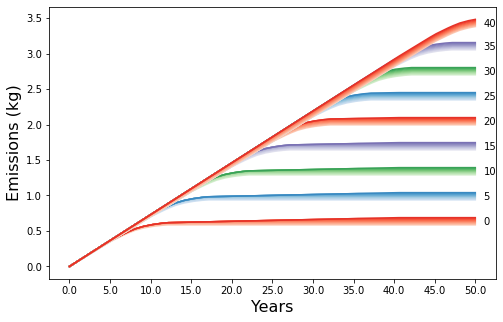

In [87]:
fig, ax = plt.subplots(figsize = [8,5])

for year_ret in coal_year_range[::5]:
    color = iter(colors_dict[year_ret](np.linspace(0.2, 1, 15)))
    print(colors_dict[year])
    for year in coal_year_range[::5]:
        c = next(color)
        plt.plot(E_CO2_all_opts[year][year_ret].cumsum()/1e3, color = c)#, label = year_ret)
        
    ax.text(51*365, (E_CO2_all_opts[0][year_ret].cumsum()/1e3).max(), year_ret)
plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions (kg)',fontsize = 16)
ax.set_xticks(np.linspace(0, length_simulation, 11))
# Set the tick labels
ax.set_xticklabels(np.linspace(0, years, 11));
#plt.xlim(0,500)
#plt.legend(title = 'Years under \n operation')


In [95]:
from itertools import cycle

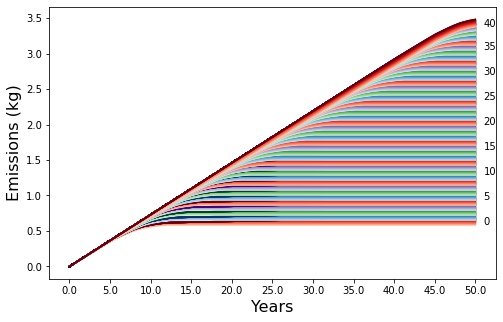

In [99]:
fig, ax = plt.subplots(figsize = [8,5])
color_choice = iter(cycle([cm.Reds, cm.Blues, cm.Greens, cm.Purples]));
for year_ret in coal_year_range:
    color_c = next(color_choice)
    color = iter(color_c(np.linspace(0.2, 1, 41)))
    for year in coal_year_range:
        c = next(color);
        plt.plot(E_CO2_all_opts[year][year_ret].cumsum()/1e4, color = c);
for year_ret in coal_year_range[::5]: 
    ax.text(51*365, (E_CO2_all_opts[0][year_ret].cumsum()/1e4).max(), year_ret);
plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions (kg)',fontsize = 16)
ax.set_xticks(np.linspace(0, length_simulation, 11))
# Set the tick labels
ax.set_xticklabels(np.linspace(0, years, 11));
#plt.xlim(0,500)
#plt.legend(title = 'Years under \n operation')


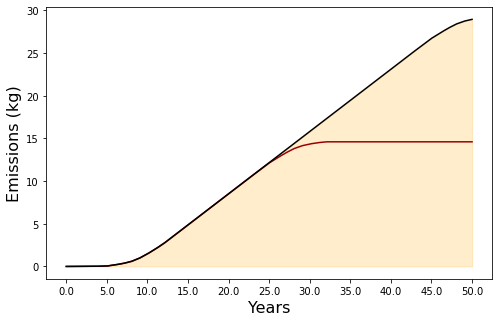

In [111]:
fig, ax = plt.subplots(figsize = [8,5])
color = iter(cm.gist_heat_r(np.linspace(0.2, 1, 41)))

plt.plot(E[20].cumsum()/1e3, color = cm.gist_heat_r(np.linspace(0.2, 1, 41))[20])
plt.plot(E[40].cumsum()/1e3, color = cm.gist_heat_r(np.linspace(0.2, 1, 41))[40])
plt.fill_between(np.arange(0,50*365), E[0].cumsum()/1e3, E[40].cumsum()/1e3, color = 'orange', alpha = .2)
plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions (kg)',fontsize = 16)
ax.set_xticks(np.linspace(0, length_simulation, 11))
# Set the tick labels
ax.set_xticklabels(np.linspace(0, years, 11));
#plt.xlim(0,500)
#plt.legend(title = 'Years under \n operation')


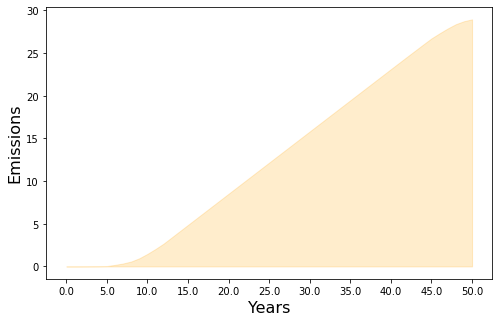

In [112]:
fig, ax = plt.subplots(figsize = [8,5])
color = iter(cm.gist_heat_r(np.linspace(0.2, 1, 41)))

#plt.plot(E[20].cumsum()/1e3, color = cm.gist_heat_r(np.linspace(0.2, 1, 41))[20])
#plt.plot(E[40].cumsum()/1e3, color = cm.gist_heat_r(np.linspace(0.2, 1, 41))[40])
plt.fill_between(np.arange(0,50*365), E[0].cumsum()/1e3, E[40].cumsum()/1e3, color = 'orange', alpha = .2)
plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions',fontsize = 16)
ax.set_xticks(np.linspace(0, length_simulation, 11))
# Set the tick labels
ax.set_xticklabels(np.linspace(0, years, 11));
#plt.xlim(0,500)
#plt.legend(title = 'Years under \n operation')


# Convolve with G

In [131]:
#import the green's function and set our time step
G = xr.open_dataarray('Outputs/G_SEA_BC_total.nc4')
dt = 1 #day

In [132]:
#a floating pt is a byte * 8e-9 to get gbytes
np.product(G.shape)*8e-9

1.73187072

In [134]:
G_lev0 = G.isel(lev = 0).sel().compute()

In [135]:
np.product(G_lev0.shape)*8e-9

0.02405376

In [136]:
%%time
### global average
C = {}
for year in [20]:
    C[year] = utils.convolve_single_lev(G_lev0, E[year])

CPU times: user 3min 6s, sys: 1.74 s, total: 3min 8s
Wall time: 3min 8s


In [32]:
for year in [20]:
    C[year]*=1e9


In [137]:

C_heavy_50perc = utils.convolve_single_lev(G_lev0, E_CO2_range_max_20yr[50])
C_heavy_50perc*=1e9

In [231]:

C_heavy_emit = utils.convolve_single_lev(G_lev0, E_heavy_emit)
C_heavy_emit*=1e9

In [33]:
C_heavy_emit_year = utils.convolve_single_lev(G_lev0, E_heavy_emit_year)
C_heavy_emit_year*=1e9

In [36]:
for s in (np.arange(0.,41.)*365.):
    #print(s)
    fig, ax = plt.subplots(figsize = [10,5], subplot_kw={'projection':ccrs.PlateCarree()})
    C[15].sel(s = s).plot(transform = ccrs.PlateCarree(), cmap = 'Reds', vmin = 0, vmax = 7e-8, extend = 'max')
    ax.coastlines()
    ax.add_feature(cfeat.STATES)
    plt.title(s/365);
    idx = (s/365.).astype(np.int32)
    plt.savefig('figures/' + f"{idx:04d}.png", dpi = 150, bbox_inches = 'tight')
    plt.close()

0.0
365.0
730.0
1095.0
1460.0
1825.0
2190.0
2555.0
2920.0
3285.0
3650.0
4015.0
4380.0
4745.0
5110.0
5475.0
5840.0
6205.0
6570.0
6935.0
7300.0
7665.0
8030.0
8395.0
8760.0
9125.0
9490.0
9855.0
10220.0
10585.0
10950.0
11315.0
11680.0
12045.0
12410.0
12775.0
13140.0
13505.0
13870.0
14235.0
14600.0


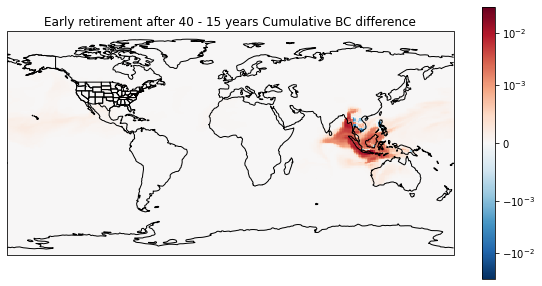

In [113]:
fig, ax = plt.subplots(figsize = [10,5], subplot_kw={'projection':ccrs.PlateCarree()})
(C[40].sum(dim = 's') - C[15].sum(dim = 's')).plot(transform = ccrs.PlateCarree(), norm = SymLogNorm(linthresh = 1e-3), cmap = 'RdBu_r')
ax.coastlines()
ax.add_feature(cfeat.STATES)
plt.title('Early retirement after 40 - 15 years Cumulative BC difference');

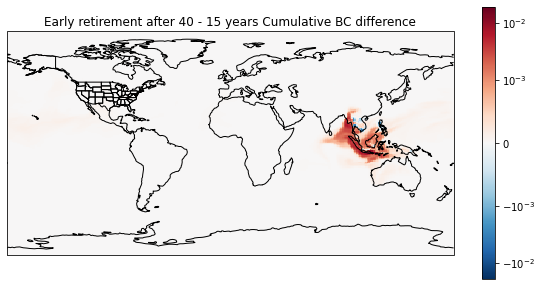

In [114]:
fig, ax = plt.subplots(figsize = [10,5], subplot_kw={'projection':ccrs.PlateCarree()})
(C[30].sum(dim = 's') - C[15].sum(dim = 's')).plot(transform = ccrs.PlateCarree(), norm = SymLogNorm(linthresh = 1e-3), cmap = 'RdBu_r')
ax.coastlines()
ax.add_feature(cfeat.STATES)
plt.title('Early retirement after 30 - 15 years Cumulative BC difference');

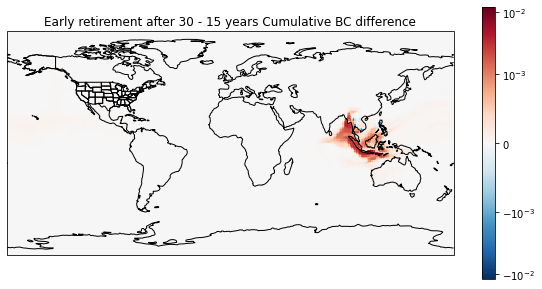

In [115]:
fig, ax = plt.subplots(figsize = [10,5], subplot_kw={'projection':ccrs.PlateCarree()})
(C[40].sum(dim = 's') - C[30].sum(dim = 's')).plot(transform = ccrs.PlateCarree(), norm = SymLogNorm(linthresh = 1e-3), cmap = 'RdBu_r')
ax.coastlines()
ax.add_feature(cfeat.STATES)
plt.title('Early retirement after 30 - 15 years Cumulative BC difference');

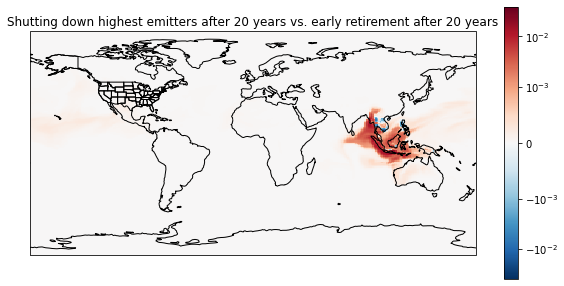

In [47]:
fig, ax = plt.subplots(figsize = [10,5], subplot_kw={'projection':ccrs.PlateCarree()})
(C_heavy_emit.sum(dim = 's')- C[20].sum(dim = 's')).plot(transform = ccrs.PlateCarree(), norm = SymLogNorm(linthresh = 1e-3), cmap = 'RdBu_r')
ax.coastlines()
ax.add_feature(cfeat.STATES)
plt.title('Shutting down highest emitters after 20 years vs. early retirement after 20 years');

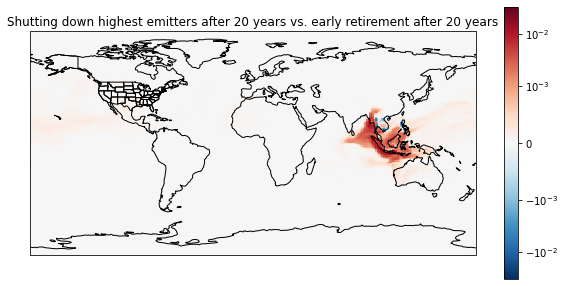

In [237]:
fig, ax = plt.subplots(figsize = [10,5], subplot_kw={'projection':ccrs.PlateCarree()})
(C_heavy_emit_year.sum(dim = 's')- C[20].sum(dim = 's')).plot(transform = ccrs.PlateCarree(), norm = SymLogNorm(linthresh = 1e-3), cmap = 'RdBu_r')
ax.coastlines()
ax.add_feature(cfeat.STATES)
plt.title('Shutting down highest emitters after 20 years vs. early retirement after 20 years');

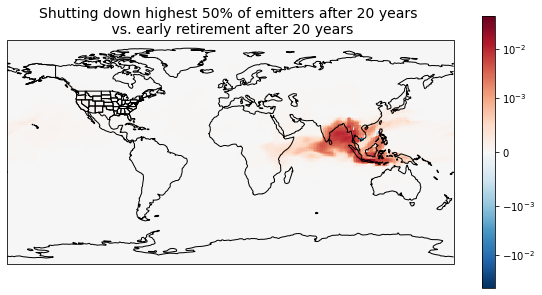

In [141]:
fig, ax = plt.subplots(figsize = [10,5], subplot_kw={'projection':ccrs.PlateCarree()})
(C_heavy_50perc.sum(dim = 's')- C[20].sum(dim = 's')).plot(transform = ccrs.PlateCarree(), norm = SymLogNorm(linthresh = 1e-3), cmap = 'RdBu_r')
ax.coastlines()
ax.add_feature(cfeat.STATES)
plt.title('Shutting down highest 50% of emitters after 20 years \n vs. early retirement after 20 years', fontsize = 14);